In [ ]:
!rm -rf Images
!rm -rf list_attribute.txt
!rm -rf dataset.zip
!rm -rf gender
!rm -rf train
!rm -rf val
!rm -rf test
!rm -rf female
!rm -rf male

In [ ]:
!pip install gdown

In [ ]:
# Import library
import os
import shutil
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Torch dan TorchVision library untuk deep learning
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets, models

# gdown untuk mendownload file dari Google Drive
import gdown

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1GKHBT_SmLBi_Lfr4VslU7dI-Wz3WM9cQ&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1GKHBT_SmLBi_Lfr4VslU7dI-Wz3WM9cQ
To: /content/list_attribute.txt
100% 26.7M/26.7M [00:01<00:00, 23.8MB/s]


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1m0h0XhMnOxxaXjX48zSJT0POPFFK7EPZ&export=download

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1m0h0XhMnOxxaXjX48zSJT0POPFFK7EPZ
From (redirected): https://drive.google.com/uc?id=1m0h0XhMnOxxaXjX48zSJT0POPFFK7EPZ&confirm=t&uuid=1b643870-e8de-4533-af97-19c310b3e2b7
To: /content/dataset.zip
100% 36.2M/36.2M [00:01<00:00, 19.9MB/s]


In [ ]:
!unzip -q dataset.zip

In [ ]:
attributes = open('list_attribute.txt').readlines()

os.makedirs('/content/male', exist_ok=True)
os.makedirs('/content/female', exist_ok=True)

for line in attributes[2:]:
    clean_attr = [int(x) for x in line.split() if x in ['-1', '1']]

    gender = clean_attr[20]

    parts = line.strip().split()
    filename = parts[0].strip()

    source_path = f'/content/Images/{filename}'

    if os.path.exists(source_path):
        if gender == 1:
            target_path = f'/content/male/{filename}'
        else:
            target_path = f'/content/female/{filename}'

        shutil.copy(source_path, target_path)

        os.remove(source_path)

print('Separating and cleaning process are done')

Separating and cleaning process are done


In [ ]:
os.makedirs('/content/train/male', exist_ok=True)
os.makedirs('/content/val/male', exist_ok=True)
os.makedirs('/content/test/male', exist_ok=True)
os.makedirs('/content/train/female', exist_ok=True)
os.makedirs('/content/val/female', exist_ok=True)
os.makedirs('/content/test/female', exist_ok=True)

male_images = os.listdir('/content/male')
female_images = os.listdir('/content/female')

male_train_val, male_test = train_test_split(male_images, test_size=0.2, random_state=42)
male_train, male_val = train_test_split(male_train_val, test_size=0.25, random_state=42)  # 0.25 dari 0.8 -> 20% val

female_train_val, female_test = train_test_split(female_images, test_size=0.2, random_state=42)
female_train, female_val = train_test_split(female_train_val, test_size=0.25, random_state=42)

def move_images(file_list, source_dir, target_dir):
    for filename in file_list:
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.move(source_path, target_path)

# Pindahkan gambar male ke folder yang sesuai
move_images(male_train, '/content/male', '/content/train/male')
move_images(male_val, '/content/male', '/content/val/male')
move_images(male_test, '/content/male', '/content/test/male')

# Pindahkan gambar female ke folder yang sesuai
move_images(female_train, '/content/female', '/content/train/female')
move_images(female_val, '/content/female', '/content/val/female')
move_images(female_test, '/content/female', '/content/test/female')

print("Pemisahan selesai.")

Pemisahan selesai.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
data_dir = '/content/'

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}

class_names = image_datasets['train'].classes

# Mengecek apakah GPU tersedia
use_gpu = torch.cuda.is_available()

print(f'Class names: {class_names}')
print(f'Training dataset size: {dataset_sizes["train"]}')
print(f'Validation dataset size: {dataset_sizes["val"]}')
print(f'Test dataset size: {dataset_sizes["test"]}')


Class names: ['female', 'male']
Training dataset size: 2998
Validation dataset size: 1001
Test dataset size: 1001


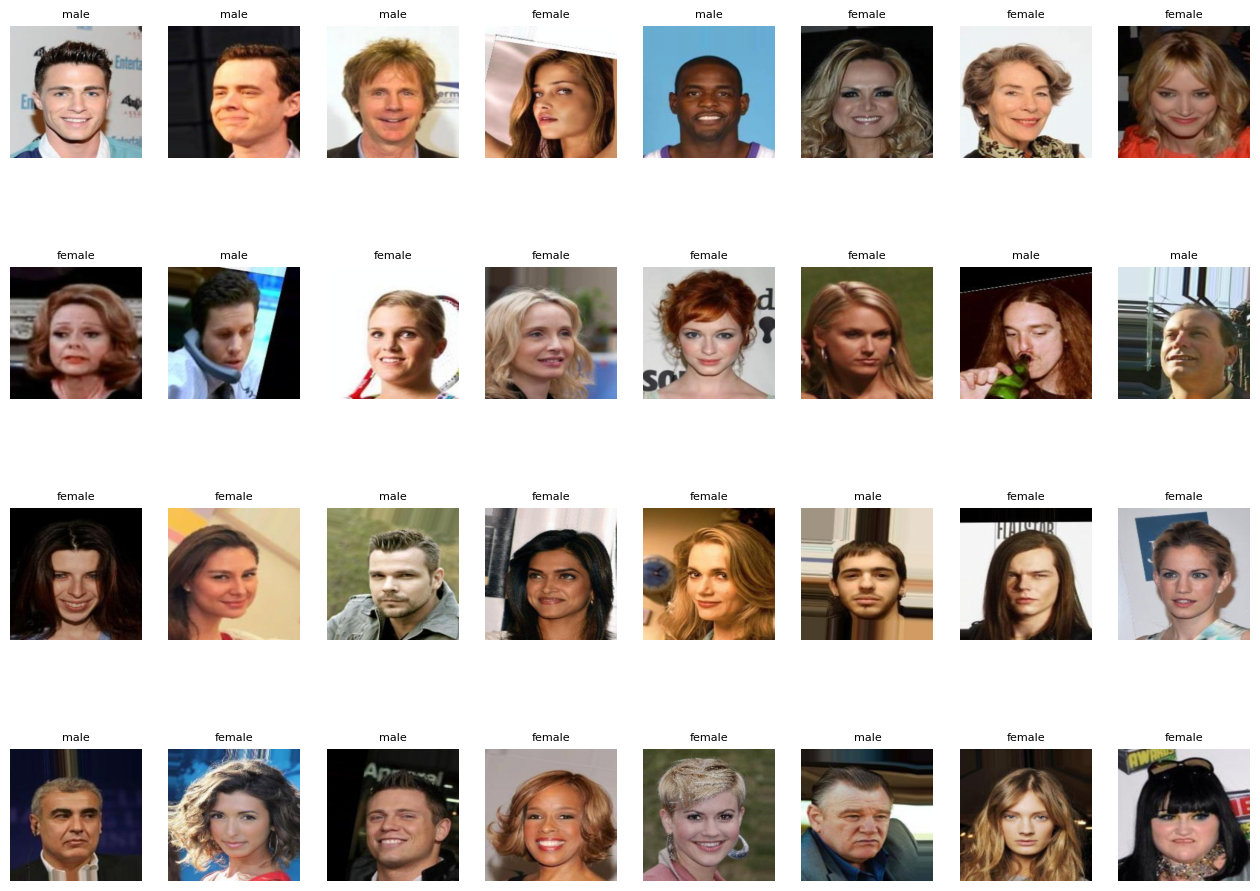

In [ ]:
def imshow_batch_with_labels(inputs, classes, class_names, cols=6, figsize=(12, 8), padding=2):
    inp = inputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    num_images = len(inputs)

    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    axes = axes.flatten() if num_images > 1 else [axes]

    for i in range(num_images):
        axes[i].imshow(inp[i])
        axes[i].set_title(class_names[classes[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.subplots_adjust(wspace=padding, hspace=padding)
    plt.show()

inputs, classes = next(iter(dataloaders['train']))

imshow_batch_with_labels(inputs, classes, class_names, cols=8, figsize=(16, 12), padding=0.2)

In [ ]:
# Load ResNet 34
weights = models.ResNet34_Weights.DEFAULT
model_ft = models.resnet34(weights=weights)

# Sesuaikan lapisan terakhir agar cocok dengan jumlah kelas (dalam hal ini 2 kelas: male dan female)
num_ftrs = model_ft.fc.in_features # untuk mendapatkan jumlah fitur input dari layer fully connected terakhir (fully connected layer) dalam model model_ft
model_ft.fc = nn.Linear(num_ftrs, 2)

# GPU
if use_gpu:
    model_ft = model_ft.cuda()

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)

# Scheduler untuk menurunkan learning rate secara bertahap
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 78.2MB/s]


In [ ]:
!mkdir gender

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    in_epoch = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Set model ke mode training dan validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Loop untuk data
            for inputs, labels in dataloaders[phase]:

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero grad
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass dan optimize hanya jika di fase training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Hitung loss dan akurasi
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./gender/point_resnet_best.pth')
                in_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print(f'In the {in_epoch}/{num_epochs} epoch')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.1747 Acc: 0.9350
val Loss: 0.1825 Acc: 0.9341

Epoch 1/49
----------
train Loss: 0.0437 Acc: 0.9877
val Loss: 0.1084 Acc: 0.9580

Epoch 2/49
----------
train Loss: 0.0205 Acc: 0.9913
val Loss: 0.1728 Acc: 0.9341

Epoch 3/49
----------
train Loss: 0.0320 Acc: 0.9887
val Loss: 0.1114 Acc: 0.9590

Epoch 4/49
----------
train Loss: 0.0087 Acc: 0.9977
val Loss: 0.1183 Acc: 0.9550

Epoch 5/49
----------
train Loss: 0.0060 Acc: 0.9990
val Loss: 0.0972 Acc: 0.9690

Epoch 6/49
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0892 Acc: 0.9700

Epoch 7/49
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.0955 Acc: 0.9650

Epoch 8/49
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.0891 Acc: 0.9720

Epoch 9/49
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0958 Acc: 0.9650

Epoch 10/49
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.0865 Acc: 0.9710

Epoch 11/49
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.0883 Acc: 0.9700

Ep

In [ ]:
checkpoint = torch.load('./gender/point_resnet_best.pth', weights_only=True)
model_ft.load_state_dict(checkpoint['model'])
model_ft.eval()

correct = 0
total = 0
total_loss = 0.0
total_batches = 0

with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        total_batches += 1

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

average_loss = total_loss / total_batches
print(f"Average Test Loss: {average_loss:.4f}")

Test Accuracy: 97.40%
Average Test Loss: 0.0815


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()


    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

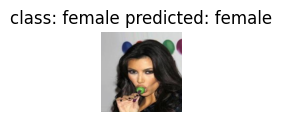

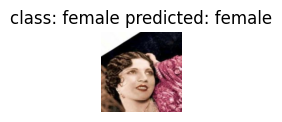

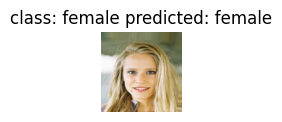

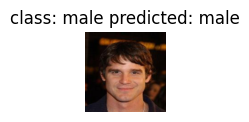

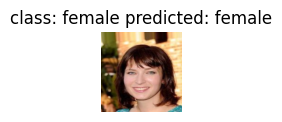

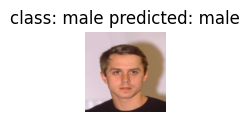

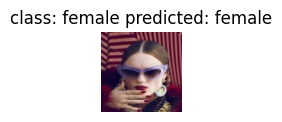

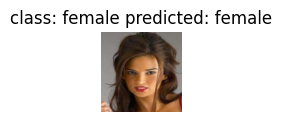

In [ ]:
visualize_model(model_ft, num_images=8)

In [ ]:
from google.colab import files
files.download('./gender/point_resnet_best.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>